# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import timm
import cv2
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import mean_absolute_error

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
workers = os.cpu_count()
print(device)

cuda


## Datasets Selection

### Training Set
   - **Description**: Contains 999 real ultrasound images.
   - **Measurements**: Includes already labeled pixel size values.

### Test Set
   - **Description**: Contains 335 real ultrasound images.
   - **Measurements**: Includes already labeled pixel size values.

In [3]:
# Set flags True to include Test set
include_test_set = True
include_gan_set = False

# Load dataframes
train_csv = pd.read_csv("/kaggle/input/fetalhcdata/training_set/training_set_circumference.csv")
if include_test_set:
    test_csv = pd.read_csv("/kaggle/input/fetalhcdata/test_set/test_set_circumference.csv")
if include_gan_set:
    gan_csv = pd.read_csv("/kaggle/input/tmpdataset/measured_circumference.csv")

# Add 'dataset' column
train_csv['dataset'] = 'train'
if include_test_set:
    test_csv['dataset'] = 'test'
if include_gan_set:
    gan_csv['dataset'] = 'gan'

## Data Preprocessing and Class Balancing
#### This code categorizes samples based on head circumference. It limits the number of samples per class based on `limit_per_class` to ensure balanced representation. The priority order is applied to select samples for removal in case of excess (highest priority starts from the right side). The resulting dataset, 'filtered_df', contains balanced samples across classes.

#### Also, the code cluster classes where we identified a small number of samples from training_set. For example, when classifying circumference, we have barely any samples in the first classes 4 and 5, so we set `lowest_value_cm` as 6 to combine them under class number 6.

#### Lastly, we have two optinal variables to adjust the sample distribution: `gan_samples_limit` allows to limit the number of GAN samples in each class, and `oversample_limit` upsamples all classes with fewer samples than the limit.

In [4]:
# Define balancing parameters
lower_bound, upper_bound = 6, 33
classes = list(range(lower_bound, upper_bound + 1))

oversample_limit, limit_per_class = 160, 225

In [5]:
def classify_by_HC(df, map_from_zero = False):
    
    def round_classification(value):
        rounded_value = int(np.round(value / 10))
        if rounded_value <= lower_bound:
            return lower_bound
        elif rounded_value > upper_bound:
            return upper_bound
        else:
            return rounded_value

    df['class'] = df['Head_Circumference_mm'].apply(round_classification)

    num_classes = df['class'].nunique()
    
    if map_from_zero:
        # Normalize class labels to start from 0
        unique_classes = sorted(df['class'].unique())
        class_mapping = {old_class: new_class for new_class, old_class in enumerate(unique_classes)}
        df['class'] = df['class'].map(class_mapping)

        return num_classes, class_mapping
    
    return num_classes


# Classify the dataframes
classify_by_HC(train_csv)

if include_test_set:
    classify_by_HC(test_csv)

if include_gan_set:
    classify_by_HC(gan_csv)

In [6]:
valid_ratio = 0.2

def stratified_split(df, test_size=0.2, random_state=42):
    train_df, val_df = train_test_split(df, test_size=test_size, stratify=df['class'], random_state=random_state)
    return train_df, val_df

# Split and concatenate the dataframes
labeld_train_df, val_df = stratified_split(train_csv, valid_ratio)
dfs_to_concat = [labeld_train_df]

if include_test_set:
    dfs_to_concat.append(test_csv)

if include_gan_set:
    dfs_to_concat.append(gan_csv)

merged_df = pd.concat(dfs_to_concat, ignore_index=True)

In [7]:
# Iterate over each class
for cir_class in classes:
    
    if not include_gan_set:
        continue
    
    # Filter real samples for the current class
    real_samples_in_class = merged_df[(merged_df['class'] == cir_class) & ((merged_df['dataset'] == 'test') | (merged_df['dataset'] == 'train'))]
    
    # Count real samples to set as limit for GAN samples
    gan_samples_limit = len(real_samples_in_class)
    
    # Filter GAN samples for the current class
    gan_samples_in_class = merged_df[(merged_df['class'] == cir_class) & (merged_df['dataset'] == 'gan')]
    
    if len(gan_samples_in_class) <= gan_samples_limit:
            continue
    
    # Determine how many GAN samples exceed the limit
    samples_to_remove = len(gan_samples_in_class) - gan_samples_limit

    # Sample the excess GAN images to remove
    excess_samples = gan_samples_in_class.sample(n=samples_to_remove, random_state=42)

    # Create a mask to filter out the excess samples
    indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
    
    # Update merged_df to only include samples that are not excess GAN samples
    merged_df = merged_df.loc[indices_to_keep]

In [8]:
# Priority order
priority = ['gan', 'test', 'train']

for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) == 0:
        print(f"Class {cir_class - lower_bound} has no samples")

    if len(samples_in_class) <= limit_per_class:
        continue

    excess_count = len(samples_in_class) - limit_per_class
    
    for dataset in priority:
        if excess_count <= 0:
            break
        dataset_samples = samples_in_class[(samples_in_class['dataset'] == dataset)]
        if len(dataset_samples) > 0:
            samples_to_remove = min(len(dataset_samples), excess_count)
            excess_samples = dataset_samples.sample(n=samples_to_remove, random_state=42)
            indices_to_keep = ~merged_df.set_index(['dataset', 'filename']).index.isin(excess_samples.set_index(['dataset', 'filename']).index)
            merged_df = merged_df.loc[indices_to_keep]
            excess_count -= samples_to_remove

# Oversample samples in each class until reaching limit_per_class amount of samples
for cir_class in classes:
    samples_in_class = merged_df[merged_df['class'] == cir_class]
    
    if len(samples_in_class) < oversample_limit:
        needed_samples = oversample_limit - len(samples_in_class)
        oversampled_samples = samples_in_class.sample(n=needed_samples, replace=True, random_state=42)
        merged_df = pd.concat([merged_df, oversampled_samples])

filtered_df = merged_df.copy()

# Display the filtered dataframe
filtered_df.head()

,filename,Head_Circumference_cm,Head_Circumference_mm,pixel size(mm),OFD,BPD,mask_filename,dataset,class
0,513_HC.png,17.852,178.52,0.106038,79.2,73.9,513_HC_Mask.png,train,18
1,610_HC.png,19.310,193.10,0.235891,90.2,76.7,610_HC_Mask.png,train,19
2,503_HC.png,16.660,166.60,0.128429,72.5,69.9,503_HC_Mask.png,train,17
3,377_HC.png,17.226,172.26,0.109249,74.7,71.4,377_HC_Mask.png,train,17
4,501_HC.png,17.330,173.30,0.148858,81.3,68.8,501_HC_Mask.png,train,17


## Data Classification (for data visualization)
#### The `classify_head_measurements` function categorizes measurements into classes by rounding the cm measurements and normalizing them to start from 0. It returns the number of unique classes and a mapping of original class labels to normalized ones.

In [9]:
num_classes, class_mapping = classify_by_HC(filtered_df, True)
classify_by_HC(val_df, True)
balanced_df = filtered_df.copy()

print("Class Mapping:", class_mapping)
print("Number of Classes:", num_classes)

Class Mapping: {6: 0, 7: 1, 8: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 17: 11, 18: 12, 19: 13, 20: 14, 21: 15, 22: 16, 23: 17, 24: 18, 25: 19, 26: 20, 27: 21, 28: 22, 29: 23, 30: 24, 31: 25, 32: 26, 33: 27}
Number of Classes: 28


## Plot Class Distribution Across Datasets

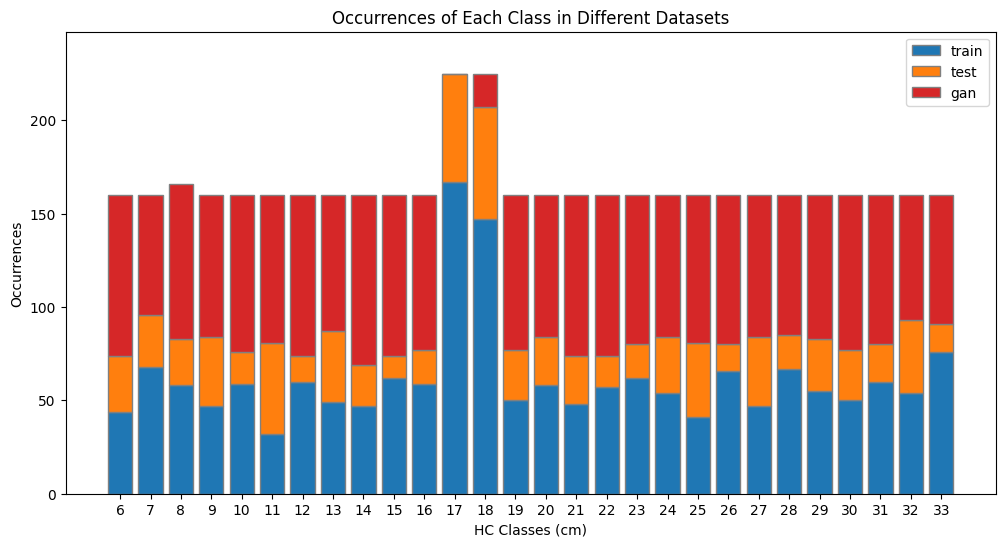

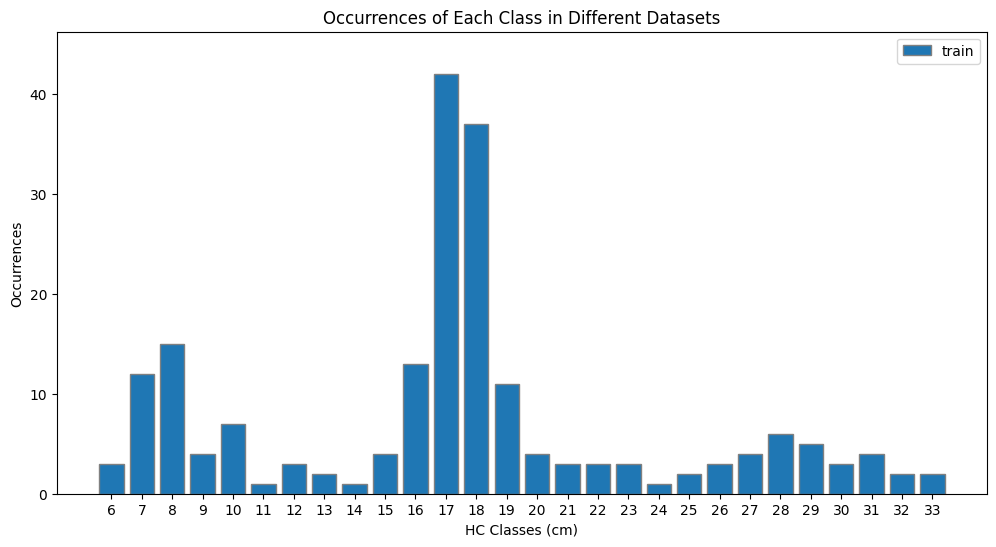

In [10]:
def plot_class_distribution(df, dataset_colors=None):
    # Make a copy of the DataFrame to avoid altering the original
    df_copy = df.copy()
    
    # Identify unique datasets in the 'dataset' column
    unique_datasets = df_copy['dataset'].unique()

    # Initialize a dictionary to hold class counts for each dataset
    class_counts_dict = {}

    # Loop through each unique dataset and count class occurrences
    for dataset in unique_datasets:
        dataset_data = df_copy[df_copy['dataset'] == dataset]
        class_counts = dataset_data['class'].value_counts().sort_index()
        class_counts_dict[dataset] = class_counts

    # Combine the counts into a single DataFrame
    class_counts = pd.DataFrame(class_counts_dict).fillna(0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Default colors if dataset_colors is not provided
    default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    if dataset_colors is None:
        dataset_colors = {}
    
    # Bar width
    bar_width = 0.35

    # Initialize bottom for stacked bars
    bottom = None

    for i, dataset in enumerate(class_counts.columns):
        if bottom is None:
            bottom = np.zeros_like(class_counts[dataset])

        # Get color for current dataset
        color = dataset_colors.get(dataset, default_colors[i % len(default_colors)])

        ax.bar(class_counts.index, class_counts[dataset], bottom=bottom, color=color, edgecolor='grey', label=dataset)
        bottom += class_counts[dataset]

    # Add labels
    ax.set_xlabel('HC Classes (cm)')
    ax.set_ylabel('Occurrences')
    ax.set_title('Occurrences of Each Class in Different Datasets')
    ax.legend()

    # Set x-axis tick labels with class numbers
    ax.set_xticks(range(len(class_counts)))
    ax.set_xticklabels(class_counts.index + lower_bound)

    # Increase y-axis limit a little more than the top value
    max_count = class_counts.sum(axis=1).max()
    ax.set_ylim(0, max_count * 1.1)

    # Show plot
    plt.show()

dataset_colors = {'train': '#1f77b4', 'test': '#ff7f0e', 'gan': '#d62728'}
plot_class_distribution(balanced_df, dataset_colors)
plot_class_distribution(val_df, dataset_colors)

## Initialize PSDataset Class

In [11]:
class PSDataset(Dataset):
    def __init__(self, df, dataset_paths, transform=None, init_transforms=None):
        self.images = [
            os.path.join(dataset_paths[dataset], filename)
            for filename, dataset in zip(df['filename'], df['dataset'])
        ]
        self.Y = df['pixel size(mm)'].astype(float).tolist()
        self.hc = df['Head_Circumference_mm'].astype(float).tolist()
        self.dataset = df['dataset'].tolist()
        self.transform = transform
        
        # Load images into memory with preprocessing
        self.loaded_images = []
        for idx, img_path in tqdm(enumerate(self.images), total=len(self.images), desc="Loading Images"):
            img = Image.open(img_path)
            if init_transforms:
                img = init_transforms(img)
            self.loaded_images.append(img)

    def __len__(self):
        return len(self.loaded_images)

    def __getitem__(self, idx):
        # Extract the image
        image = self.loaded_images[idx]
        
        if self.transform:
            image = self.transform(image)

        # Extract name and value from the dataframe
        value = self.Y[idx]
        circumference = self.hc[idx]
        dataset = self.dataset[idx]

        # Convert target value to torch.float32
        value = torch.tensor(value, dtype=torch.float32).unsqueeze(0)

        return image, value, circumference, dataset

In [12]:
img_size = 512 # 512 is better

init_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((540, 800)),
    transforms.Resize(size=img_size),
])

final_transforms = [
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, True),
    transforms.Normalize((0.5,), (0.5,))
]

transform_train = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(size=img_size),
    transforms.RandomErasing(p=0.5, scale=(0.05, 0.15), ratio=(0.3, 3.3)),
] + final_transforms)

val_final_transfomrs = final_transforms.copy()
val_final_transfomrs.insert(0, transforms.CenterCrop(size=img_size))

validation_transforms = [
    transforms.Compose(val_final_transfomrs),  # No flip
    transforms.Compose([transforms.RandomVerticalFlip(p=1.0)] + val_final_transfomrs),  # Vertical flip
    transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)] + val_final_transfomrs),  # Horizontal flip
    transforms.Compose([transforms.RandomVerticalFlip(p=1.0), transforms.RandomHorizontalFlip(p=1.0)] + val_final_transfomrs)  # Both flips
]

In [13]:
dataset_paths = {
    'train': '/kaggle/input/fetalhcdata/training_set/training_set',
    'test': '/kaggle/input/fetalhcdata/test_set/test_set',
    'gan': '/kaggle/input/fetalhcdata/gan_set_v2/gan_images'
}

# Create training dataset
train_dataset = PSDataset(balanced_df, dataset_paths, transform_train, init_transforms)

val_datasets = []
for i, val_transform in enumerate(validation_transforms):
    val_dataset = PSDataset(val_df, dataset_paths, val_transform, init_transforms)
    val_datasets.append(val_dataset)

Loading Images: 100%|██████████| 200/200 [00:01<00:00, 101.12it/s]


In [14]:
# Define batch size
batch_size = 5

val_loaders = []

for i, val_dataset in enumerate(val_datasets):
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=workers, pin_memory=True)
    val_loaders.append(val_loader)

## Testing Class Output

In [15]:
print(len(train_dataset))
print(len(val_datasets[0]))

4616
200


Training samples:


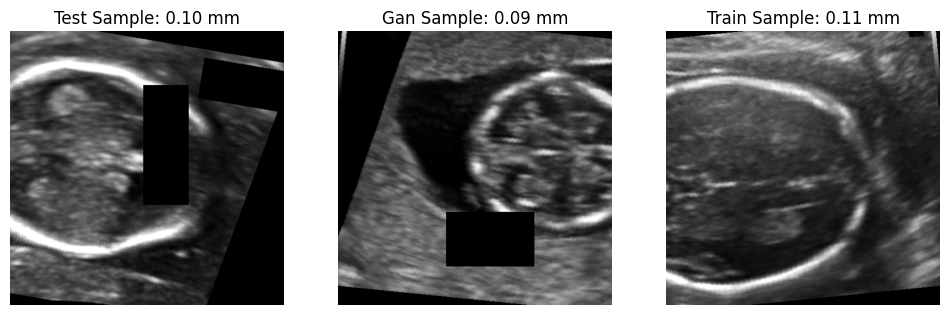

Validation samples:


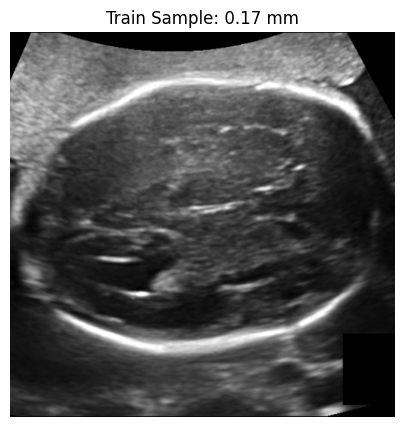

In [16]:
def plot_samples(dataset, df):
    # Get the unique dataset types from the df
    unique_dataset_types = df['dataset'].unique()

    # Dictionary to hold one sample from each dataset type
    samples = {}

    # Get indices to iterate over in random order
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)

    # Create a subplot with a single row
    plt.figure(figsize=(12, 5))

    # Counter to keep track of the current position in the subplot
    pos = 1

    # Iterate through the shuffled indices
    for idx in indices:
        batch = dataset[idx]
        img, pixel_size, dataset_type = batch[0], batch[1], batch[3]
        
        # Check the number of channels in the image tensor
        num_channels = img.shape[0]

        if dataset_type not in samples:
            samples[dataset_type] = (img, pixel_size)
            # Plot the sample
            plt.subplot(1, len(unique_dataset_types), pos)
            
            # Display based on the number of channels
            if num_channels == 3:  # RGB
                plt.imshow(img.permute(1, 2, 0))
            elif num_channels == 1:  # Grayscale
                plt.imshow(img.squeeze(), cmap='gray')
            
            # Convert tensor to a scalar value
            plt.title(f'{dataset_type.capitalize()} Sample: {pixel_size.item():.2f} mm')
            plt.axis('off')
            pos += 1

        # If all dataset types are found, exit the loop
        if len(samples) == len(unique_dataset_types):
            break

    plt.show()

print("Training samples:")
plot_samples(train_dataset, balanced_df)
print("Validation samples:")
plot_samples(val_datasets[0], val_df)

In [17]:
# Get the image paths from both datasets
train_image_paths = set(train_dataset.images)
val_image_paths = set(val_datasets[0].images)

# Check for any common paths
common_paths = train_image_paths.intersection(val_image_paths)

# Print out the results
if common_paths:
    print(f"Found {len(common_paths)} common image paths between training and validation datasets:")
    for path in common_paths:
        print(path)
else:
    print("No common image paths found between training and validation datasets.")

No common image paths found between training and validation datasets.


## Training the Model

In [18]:
def train_and_validate(model, train_dataset, validation_loader, criterion, optimizer, epochs=5, train_loss_threshold=None):
    train_running_loss_history = []
    validation_running_loss_history = []
    lr_history = []
    prev_val_loss = float('inf')
    early_stop = False

    # Calculate the total number of steps in one cycle (total batches across all epochs)
    num_batches = (len(train_dataset) + batch_size - 1) // batch_size
    total_steps = epochs * num_batches
    
    # Define the OneCycleLR scheduler
    init_lr = optimizer.param_groups[0]['lr']
    scheduler = OneCycleLR(optimizer, max_lr=init_lr * 10, total_steps=total_steps)

    # Use tqdm as a context manager for epochs
    with tqdm(total=epochs, desc="Training Progress", leave=True, dynamic_ncols=True) as progress_bar:
        for e in range(epochs):
            train_running_loss = 0.0
            validation_running_loss = 0.0
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)
            
            if early_stop:
                break

            model.train()
            # Training loop
            for ith_batch, sample_batched in enumerate(train_loader):
                x_train, y_train = sample_batched[:2]
                X_train = x_train.to(device)
                Y_train = y_train.to(device)

                optimizer.zero_grad()
                y_pred = model(X_train)

                # Calculate losses
                loss = criterion(y_pred, Y_train)

                # Backward and optimize
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item()
                
                # Step the scheduler
                scheduler.step()
                lr_history.append(optimizer.param_groups[0]['lr'])

            # Validation loop
            with torch.no_grad():
                model.eval()
                for ith_batch, sample_batched in enumerate(validation_loader):
                    x_val, y_val = sample_batched[:2]
                    X_val = x_val.to(device)
                    Y_val = y_val.to(device)

                    pred_val = model(X_val)
                    
                    # Calculate losses
                    val_loss = criterion(pred_val, Y_val)
                    
                    validation_running_loss += val_loss.item()

                train_epoch_loss = train_running_loss / len(train_loader)
                validation_epoch_loss = validation_running_loss / len(validation_loader)

                train_running_loss_history.append(train_epoch_loss)
                validation_running_loss_history.append(validation_epoch_loss)
                
                # Update tqdm with train and validation loss for the current epoch
                progress_bar.set_description(f"Epoch {e+1}: Train Loss = {train_epoch_loss:.5f}, Val Loss = {validation_epoch_loss:.5f}")
                progress_bar.update(1)

                if train_loss_threshold is not None:
                    if train_epoch_loss < train_loss_threshold and validation_epoch_loss >= prev_val_loss:
                        progress_bar.set_description(f"Stopping early: Train Loss = {train_epoch_loss:.5f}, Val Loss = {validation_epoch_loss:.5f}")
                        early_stop = True
                    prev_val_loss = validation_epoch_loss

            torch.cuda.empty_cache()

    # Plot loss history
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_running_loss_history, label='Train Loss')
    plt.plot(validation_running_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot learning rate
    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label='Learning Rate')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
def get_parameters(model, full_finetuning, fc_layer=None):
    
    if full_finetuning:
        # Unfreeze all layers
        for param in model.parameters():
            param.requires_grad = True
        onedim_params = [p for p in model.parameters() if p.ndim == 1]
        other_params = [p for p in model.parameters() if p.ndim != 1]
    else:
        # Freeze all layers except the specified layer
        for param in model.parameters():
            param.requires_grad = False
        
        # Check if the model has a classifier or fc layer
        if hasattr(model, 'head') and hasattr(model.head, 'fc'):
            fc_layer = model.head.fc
        elif hasattr(model, 'classifier'):
            fc_layer = model.classifier
        elif hasattr(model, 'fc'):
            fc_layer = model.fc
        else:
            # Use the provided fc_layer if neither exists in the model
            fc_layer = fc_layer if fc_layer is not None else model.classifier

        # Unfreeze the parameters of the selected layer
        for param in fc_layer.parameters():
            param.requires_grad = True

        onedim_params = [p for p in fc_layer.parameters() if p.ndim == 1]
        other_params = [p for p in fc_layer.parameters() if p.ndim != 1]

    parameters = [
        {'params': other_params},
        {'params': onedim_params, 'weight_decay': 0}
    ]
    
    return parameters

model.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Epoch 10: Train Loss = 0.00103, Val Loss = 0.00226: 100%|██████████| 10/10 [02:55<00:00, 17.52s/it]


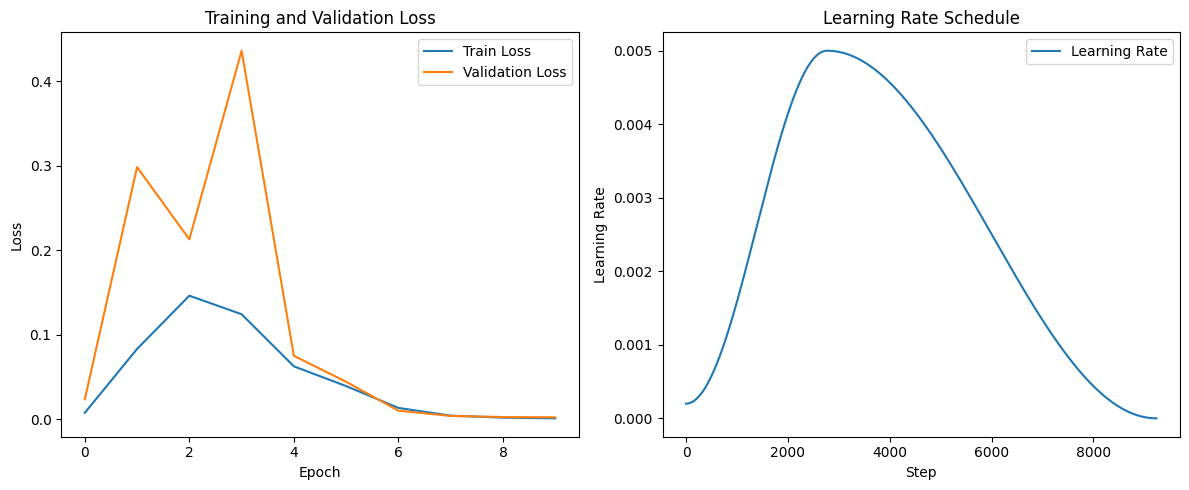

Epoch 15: Train Loss = 0.00003, Val Loss = 0.00007: 100%|██████████| 15/15 [12:29<00:00, 49.94s/it]


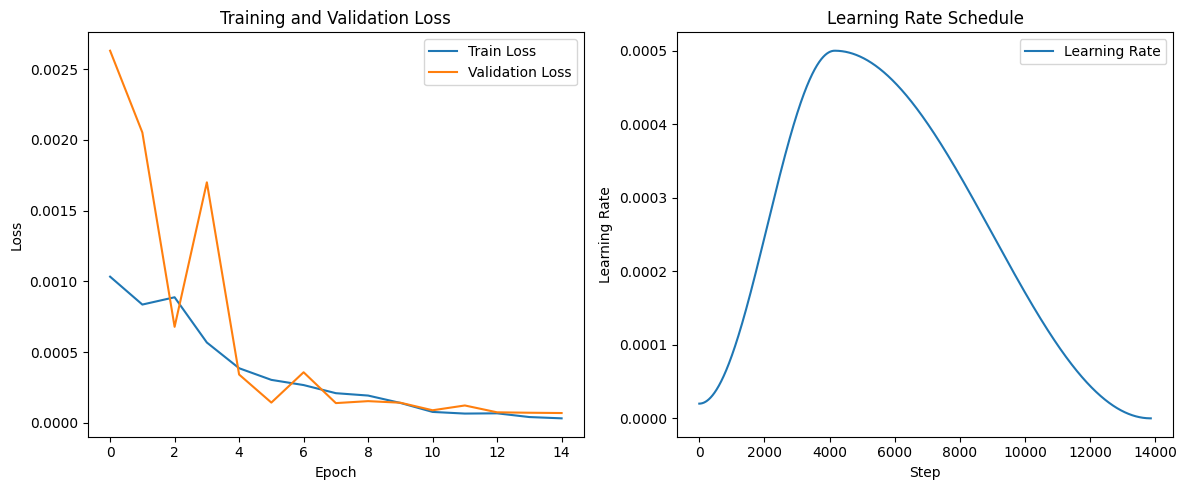

In [20]:
# Define your hyperparameters
classifier_epochs = 10
full_epochs = 15
learning_rate = 0.0005
weight_decay = 0.0005

# Define loss
criterion = nn.MSELoss()

# Load pre-trained model
model = timm.create_model('mobilenetv3_large_100.miil_in21k_ft_in1k', pretrained=True, num_classes=1, in_chans=1)

if hasattr(model, 'classifier'):
    model.classifier = nn.Linear(model.classifier.in_features, 1)
elif hasattr(model, 'fc'):
    model.fc = nn.Linear(model.fc.in_features, 1)

params = get_parameters(model, full_finetuning=False)

classifier_opt = optim.AdamW(params, lr=learning_rate)

model.to(device)

train_and_validate(model, train_dataset, val_loaders[0], criterion, classifier_opt, classifier_epochs)

params = get_parameters(model, full_finetuning=True)

full_opt = optim.AdamW(params, lr=learning_rate/10, weight_decay=weight_decay)

train_and_validate(model, train_dataset, val_loaders[0], criterion, full_opt, full_epochs)

## Evaluation

In [21]:
def evaluate_model_mae(models, dataloaders):
    # Ensure models is a list, even if a single model is passed
    if not isinstance(models, list):
        models = [models]
    
    # Set all models to evaluation mode
    for model in models:
        model.eval()
    
    all_preds = []
    all_targets = []

    # Iterate through batches of each dataloader at the same time
    with torch.no_grad():
        for batches in zip(*dataloaders):
            dl_preds = []
            targets = None
            pixel_size = None
            
            # Loop through each dataloader's batch
            for batch in batches:  # (batch1_d1, batch1_d2, ...)
                inputs, batch_targets = batch[0], batch[1]
                inputs = inputs.to(device)

                # Assign targets once (since they are the same across batches)
                if targets is None:
                    targets = batch_targets.cpu().numpy()

                models_preds = []

                # Get predictions from all models
                for model in models:
                    batch_outputs = model(inputs).cpu().numpy()
                    models_preds.append(batch_outputs)
                
                # Calculate the element-wise average of predictions from all models
                avg_model_preds = np.mean(np.array(models_preds), axis=0)
                
                dl_preds.append(avg_model_preds)

            # Calculate the element-wise average of predictions across dataloaders
            avg_batch_preds = np.mean(np.array(dl_preds), axis=0)
            
            all_preds.append(avg_batch_preds)
            all_targets.append(targets)

    # Convert lists to arrays for metric calculations
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(all_targets, all_preds)
    
    return mae

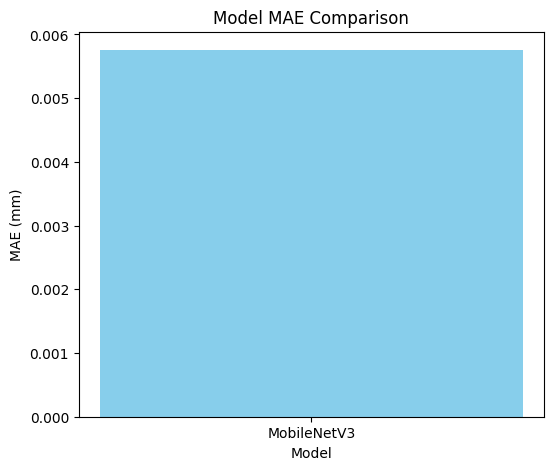

MobileNetV3 MAE (mm): 0.0058


In [22]:
# Evaluate MAE for each model individually
models = [model]
maes = []
for model in models:
    mae = evaluate_model_mae(model, val_loaders)
    model_name = model.__class__.__name__
    maes.append((model_name, mae))

# Calculate the ensemble MAE by averaging predictions across all models
if len(models) > 1:
    ensemble_mae, _ = evaluate_model_mae(models, val_loaders)
    maes.append(("Ensemble", ensemble_mae))

# Sort the models and MAEs in ascending order of MAE (lower is better)
maes.sort(key=lambda x: x[1])

# Unzip the sorted pairs back into two lists
sorted_model_names, sorted_maes = zip(*maes)

# Plotting the MAE results
plt.figure(figsize=(6, 5))
plt.bar(sorted_model_names, sorted_maes, color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAE (mm)')
plt.title('Model MAE Comparison')
plt.show()

# Print the MAE results
for name, mae in maes:
    print(f'{name} MAE (mm): {mae:.4f}')

In [29]:
from collections import Counter

def classify_error_range(error, range_size=0.01):
    range_start = (error // range_size) * range_size
    range_end = range_start + range_size
    return f"{range_start}-{range_end}"

def calculate_model_accuracy(model, dataloaders, threshold=0.01):
    total_samples = 0
    correct_predictions = 0
    saved_values = []
    error_ranges = []

    # Create a single batch dataloader for each dataloader in the list
    single_batch_loaders = [DataLoader(loader.dataset, batch_size=1, shuffle=False) for loader in dataloaders]

    # Set the model to evaluation mode
    model.eval()

    for i, batches in enumerate(zip(*single_batch_loaders)):
        # Unpack the batch for each dataloader
        X_vals = [batch[0].to(device) for batch in batches]
        y_val = batches[0][1].item()

        with torch.no_grad():
            # Initialize prediction list for averaging across dataloaders
            model_predictions = np.zeros(len(dataloaders))

            # Forward pass and collect predictions across dataloaders
            for k, X_val in enumerate(X_vals):
                batch_outputs = model(X_val).item()
                model_predictions[k] = batch_outputs

            # Calculate the mean of the predictions across dataloaders
            y_pred = np.mean(model_predictions)

            # Calculate accuracy based on the condition
            error = abs(y_pred - y_val)
            if error <= threshold:
                correct_predictions += 1
            else:
                saved_values.append(int(y_val / 0.01))
                error_range = classify_error_range(error, threshold)
                error_ranges.append(error_range)

            total_samples += 1
    
    # Calculate average accuracy
    average_accuracy = correct_predictions / total_samples

    return average_accuracy, saved_values, error_ranges

def plot_value_counts(saved_values):
    counts = Counter(saved_values)
    values = list(counts.keys())
    occurrences = list(counts.values())

    plt.bar(values, occurrences)
    plt.xlabel('Circumference')
    plt.ylabel('Occurrences')
    plt.title('Count of Circumference Ranges')
    plt.show()

def plot_error_counts(error_ranges):
    counts = Counter(error_ranges)
    ranges = list(counts.keys())
    occurrences = list(counts.values())

    # Convert range strings to tuples of floats for sorting
    parsed_ranges = [(float(r.split('-')[0]), float(r.split('-')[1])) for r in ranges]
    sorted_indices = sorted(range(len(parsed_ranges)), key=lambda i: parsed_ranges[i])

    # Sort ranges and occurrences based on the sorted indices
    sorted_ranges = [ranges[i] for i in sorted_indices]
    sorted_occurrences = [occurrences[i] for i in sorted_indices]

    plt.bar(sorted_ranges, sorted_occurrences)
    plt.xlabel('Error Range (mm)')
    plt.ylabel('Occurrences')
    plt.title('Count of Errors by Range')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### The variable `saved_values` contains the number of incorrect predictions (beyond the threshold) in each 10 mm range of circumference (similar to the class distribution at the beginning). To see the number of incorrect prediction for each 0.01 distance range from the actual answer you can use `error_ranges`.

In [30]:
best_accuracy = 0
best_saved_values = None
best_error_ranges = None

for model in models:
    # Calculate accuracies and save values for each model
    average_accuracy, saved_values, error_ranges = calculate_model_accuracy(model, val_loaders)
    
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_saved_values = saved_values
        best_error_ranges = error_ranges

    # Print the accuracy for each model
    print(f'{model.__class__.__name__} accuracy: {average_accuracy:.4f}')

MobileNetV3 accuracy: 0.8650


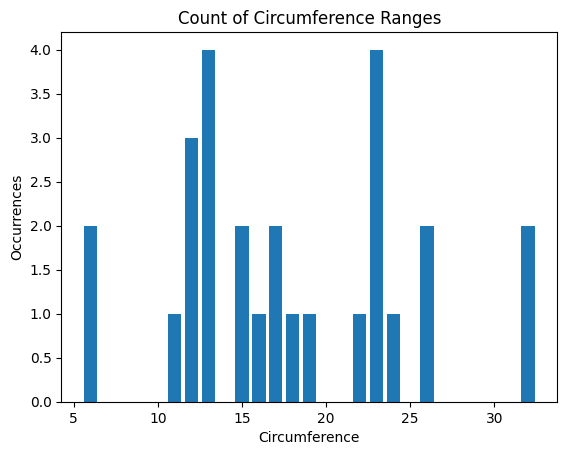

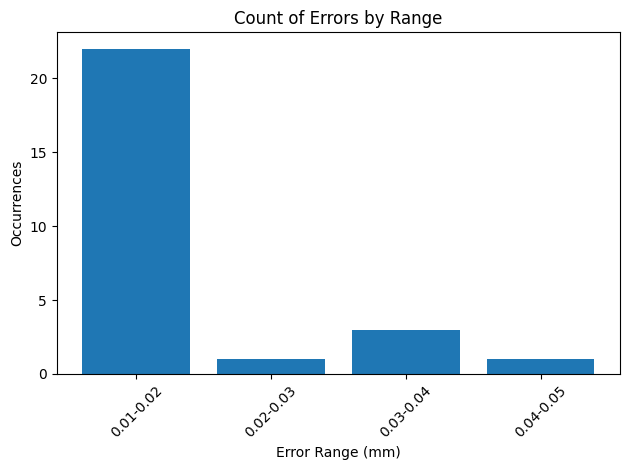

In [31]:
plot_value_counts(best_saved_values)
plot_error_counts(best_error_ranges)

## Download models

In [32]:
torch.save(model.state_dict(), "ps_model.pth")